## Volatility Forecasting - Using GARCH
#### Volatility forecasting plays a crucial role in various financial applications, including risk management, portfolio optimization and derivative pricing. Accurately predicting volatility allows market participants to make more informed decisions and mitigate potential risks effectively. 

    GARCH (Generalized AutoRegressive Conditional Heteroscedasticity) is a time series model specifically designed to model and forecast volatility clustering in financial data.

    The core problem GARCH solves is Volatility Clustering:
    Financial returns exhibit a phenomenon where high volatility periods are followed by high volatility and low volatility periods are followed by low volatility. Traditional models assume constant variance, but markets clearly shows Periods of calm (low volatility) & Periods of turbulence (high volatility)

### Why Traditional Models Like ARIMA Falls Short?
- ARIMA models the mean of a time series (predicts future values) and Assumes constant variance over time (homoscedasticity)
- Cannot capture volatility dynamics - treats all periods as equally risky

### GARCH models two equations simultaneously:

- Mean Equation (Auto Regressive Part):  
**r(t) = μ + ε(t)**
- Variance Equation (Condoitional Heteroscedasticity Part):  
**σ²(t) = ω + α₁ε²(t-1) + β₁σ²(t-1)**

Where the current volatility depends on:

- Recent shocks **(α₁ε²(t-1))**

- Past volatility **(β₁σ²(t-1))**

---

## Data Loading

In [12]:
import pandas as pd 
import numpy as np
import yfinance as yf

# Fetch data for RELIANCE from Yahoo Finance
ticker = 'RELIANCE.NS'
start_date = '2019-01-01'
end_date = '2024-07-29'

# Download the data
stock_data = yf.download(ticker, start=start_date, end=end_date)
stock_data  = stock_data.dropna() 

# stock_data

[*********************100%***********************]  1 of 1 completed


## Calculate Returns
In financial analysis, we focus on returns rather than raw stock prices for several fundamental reasons:
#### 1. Comparability Across Stocks 
    Returns standardize performance so we can compare different stocks or portfolios regardless of their price level.
**Example:** A ₹100 stock increasing to ₹110 and a ₹1,000 stock increasing to ₹1,100 both give a 10% return, even though the absolute price change differs.

#### 2. Stationarity
    Returns shows the properties of stationarity such as constant mean, constant variance and constant autocorrelation whereas the raw stock prices shows non-stationary properties, which is crucial for time series forecasting, risk modeling, and models like GARCH or ARIMA.


In [17]:
def calculate_returns(data):
    prices = data['Close'].copy()

    # Creating a DataFrame to store different types of returns
    returns = pd.DataFrame(index=prices.index)

    returns['Simple Returns'] = prices.pct_change()    # Simple returns
    returns['Log Returns'] = np.log(prices / prices.shift(1))   # Log returns
    returns['Log Returns %'] = np.log(prices / prices.shift(1)) * 100    # Log returns in percentage

    returns = returns.dropna()
    
    return returns 

print(calculate_returns(stock_data).head())

            Simple Returns  Log Returns  Log Returns %
Date                                                  
2019-01-02       -0.013024    -0.013110      -1.310957
2019-01-03       -0.012337    -0.012414      -1.241392
2019-01-04        0.005399     0.005385       0.538460
2019-01-07        0.005552     0.005537       0.553700
2019-01-08       -0.000091    -0.000091      -0.009052


## Visualize the Price & Returns
    Detailed visual analysis helps in identifying key characteristics of the data including price trends, volume patterns, return distribution (often showing fat tails and skewness), and volatility clustering - crucial for GARCH modeling

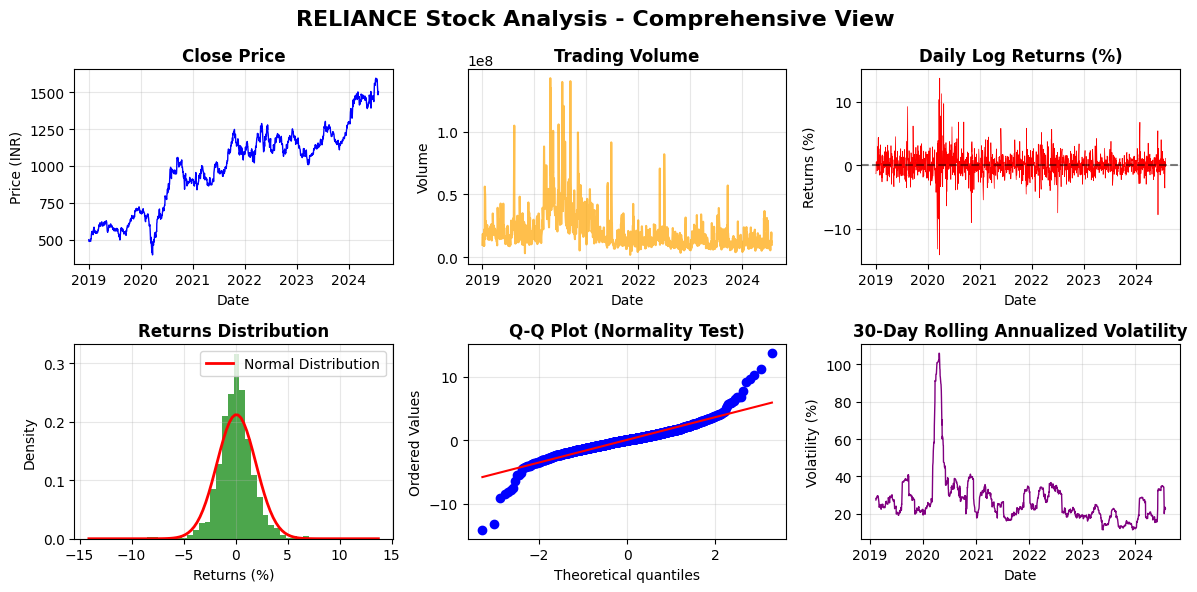

In [23]:
import matplotlib.pyplot as plt
from scipy import stats

def create_comprehensive_plots(stock_data, returns_data, symbol):
    """
    Create comprehensive visualizations for stock analysis
    """
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    fig.suptitle(f'{symbol} Stock Analysis - Comprehensive View', fontsize=16, fontweight='bold')
    
    # 1. Price Time Series
    axes[0, 0].plot(stock_data.index, stock_data['Close'], color='blue', linewidth=1)
    axes[0, 0].set_title('Close Price', fontweight='bold')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Price (INR)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Volume Analysis
    axes[0, 1].plot(stock_data.index, stock_data['Volume'], color='orange', alpha=0.7)
    axes[0, 1].set_title('Trading Volume', fontweight='bold')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Volume')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Log Returns Time Series
    axes[0, 2].plot(returns_data.index, returns_data['Log Returns %'], color='red', linewidth=0.5)
    axes[0, 2].set_title('Daily Log Returns (%)', fontweight='bold')
    axes[0, 2].set_xlabel('Date')
    axes[0, 2].set_ylabel('Returns (%)')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 4. Returns Distribution
    axes[1, 0].hist(returns_data['Log Returns %'], bins=50, density=True, alpha=0.7, color='green')
    axes[1, 0].set_title('Returns Distribution', fontweight='bold')
    axes[1, 0].set_xlabel('Returns (%)')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add normal distribution overlay
    mu, sigma = returns_data['Log Returns %'].mean(), returns_data['Log Returns %'].std()
    x = np.linspace(returns_data['Log Returns %'].min(), returns_data['Log Returns %'].max(), 100)
    normal_dist = stats.norm.pdf(x, mu, sigma)
    axes[1, 0].plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    axes[1, 0].legend()
    
    # 5. QQ Plot
    stats.probplot(returns_data['Log Returns %'], dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot (Normality Test)', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Rolling Volatility (30-day window)
    rolling_vol = returns_data['Log Returns %'].rolling(window=30).std() * np.sqrt(252)
    axes[1, 2].plot(rolling_vol.index, rolling_vol, color='purple', linewidth=1)
    axes[1, 2].set_title('30-Day Rolling Annualized Volatility', fontweight='bold')
    axes[1, 2].set_xlabel('Date')
    axes[1, 2].set_ylabel('Volatility (%)')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create comprehensive plots
returns = calculate_returns(stock_data)
create_comprehensive_plots(stock_data, returns, "RELIANCE")


#### Interpretation of the Plots
1. If we closely examine the Daily log returns chart, we can clearly observe volatility clustering—periods of high volatility (such as during the COVID-19 outbreak) are grouped together, while periods of low volatility also form distinct clusters

2. If we closely examine the Returns Distribution Plot, we can see that the returns are centered around 0, but with **Fat Tails** (bars exceeding the fitted normal curve) and also has a sharper central peak(**Leptokurtosis**) than the normal—indicating more frequent small daily movements. \
These observations implies deviation from normality, hence its better to use Student's t-distribution for the analysis.

3. The Q-Q plot explains the deviation from the line—especially at the tails—suggests high kurtosis (Leptokurtic & Fat Tails Behavior) typical in financial return series. This aligns with what we saw in the histogram earlier.


## Test for Stationarity & Autocorrelation (Volatility Clustering)
    Although log returns typically exhibit stationarity, it is advisable to confirm this using the Augmented Dickey-Fuller (ADF) test. If the returns are found to be non-stationary, transforming the series to achieve stationarity can improve model performance.

    The ADF test assesses stationarity of the return series, while the Ljung-Box test applied to squared returns helps detect ARCH effects—indicative of volatility clustering—which supports the use of GARCH-type models


In [56]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

def test_stationarity_and_autocorrelation(returns_data):
    """
    Test for stationarity and autocorrelation in the returns data
    """
    # ADF Test for Stationarity
    adf_result = adfuller(returns_data['Log Returns %'])

    if adf_result[1] < 0.05:
        print(f"p-value = {adf_result[1]} < 0.05, The series is stationary (reject null hypothesis of non-stationarity).")
    else:
        print(f"p-value = {adf_result[1]} > 0.05, The series is non-stationary (fail to reject null hypothesis of non-stationarity).")
    
    # Ljung-Box Test for Autocorrelation
    lb_result = acorr_ljungbox(returns_data['Log Returns %']**2, lags=[10], return_df=True)
    
    if lb_result.loc[10, 'lb_pvalue'] < 0.05:
        print(f"p-value = {lb_result.loc[10, 'lb_pvalue']} < 0.05, The series exhibits significant autocorrelation (reject null hypothesis of no autocorrelation).")
    else:
        print(f"p-value = {lb_result.loc[10, 'lb_pvalue']} > 0.05, The series does not exhibit significant autocorrelation (fail to reject null hypothesis of no autocorrelation).")

# Test for Stationarity & Autocorrelation
test_stationarity_and_autocorrelation(returns)     

p-value = 3.385832564160826e-20 < 0.05, The series is stationary (reject null hypothesis of non-stationarity).
p-value = 7.042008184459922e-170 < 0.05, The series exhibits significant autocorrelation (reject null hypothesis of no autocorrelation).


#### Both ADF test and Ljung-Box test rejects the null hypothesis stating that the returns series is Stationary and has significant autocorrelation ⇒ Volatility Clustering

## GARCH Model Implementation

### Model Selection: Which GARCH Model Should You Use?
    Choosing the right GARCH model depends on the market you’re analyzing and the kind of volatility you’re expecting. Each models solves specific cases.

### 1. GARCH(1,1) Model
    GARCH(1,1) Model is the basic and simple GARCH model which is widely used to capture volatility clustering in financial time series.
**When to use**: In stable markets where volatility doesn’t exhibit complex or asymmetric behavior.

In [83]:
from arch import arch_model

# Creating a list to store the GARCH model and results
model_results = []


def fit_garch_model(returns_data):
    """
    Fit a GARCH(1, 1) model to the log returns data
    """
    # Fit GARCH(1, 1) model
    model = arch_model(returns_data['Log Returns %'], vol='Garch', p=1, q=1, mean='constant', dist='Normal')
    garch_fit = model.fit(disp="off")
    
    # Store model results in dictionary
    model_results.append( {
        'Model': 'GARCH(1,1)',
        'AIC': garch_fit.aic,
        'BIC': garch_fit.bic,
        'Log-Likelihood': garch_fit.loglikelihood
    })
    
    print(garch_fit.summary())
    
    return garch_fit

# Fit GARCH(1, 1) model
garch_model = fit_garch_model(returns)


                     Constant Mean - GARCH Model Results                      
Dep. Variable:          Log Returns %   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2652.02
Distribution:                  Normal   AIC:                           5312.04
Method:            Maximum Likelihood   BIC:                           5332.94
                                        No. Observations:                 1373
Date:                Thu, Jul 31 2025   Df Residuals:                     1372
Time:                        12:23:51   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0942  4.235e-02      2.225  2.605e-02 [1.124e-0

### 2. GJR-GARCH Model
    The GJR-GARCH model is an extension of the standard GARCH model that captures asymmetric volatility, particularly the phenomenon that negative shocks (bad news) tend to increase volatility more than positive shocks (good news) of the same magnitude.

    We add a assymmetric term o=1 to the model

**When to use**: We should consider using GJR-GARCH when the financial time series data shows asymmetric volatility

In [84]:
def fit_gjr_garch_model(returns_data):
    """
    Fit a GJR-GARCH(1,1) model to the log returns data
    """
    # Fit GJR-GARCH(1,1) model
    model = arch_model(returns_data['Log Returns %'], vol='Garch', p=1, o=1, q=1, mean='constant', dist='Normal')
    gjr_garch_fit = model.fit(disp="off")
    
    # Store model results in dictionary
    model_results.append( {
        'Model': 'GJR-GARCH(1,1)',
        'AIC': gjr_garch_fit.aic,
        'BIC': gjr_garch_fit.bic,
        'Log-Likelihood': gjr_garch_fit.loglikelihood
    })
    
    print(gjr_garch_fit.summary())
    
    return gjr_garch_fit

# Fit GARCH(1, 1) model
gjr_garch_model = fit_gjr_garch_model(returns)

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:          Log Returns %   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -2642.33
Distribution:                  Normal   AIC:                           5294.67
Method:            Maximum Likelihood   BIC:                           5320.79
                                        No. Observations:                 1373
Date:                Thu, Jul 31 2025   Df Residuals:                     1372
Time:                        12:23:52   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0641  4.155e-02      1.543      0.123 [-1.73

### 3. EGARCH(Exponentail GARCH) Model
    EGARCH solves the similar problem as GJR-GARCH of modelling the assymetric volatility with more flexibility. It captures the leverage effect - i.e., negative shocks increase volatility more than positive shocks.

In [85]:
def fit_egarch_model(returns_data):
    """
    Fit a EGARCH(1,1) model to the log returns data
    """
    # Fit EGARCH(1,1) model
    model = arch_model(returns_data['Log Returns %'], vol='EGARCH', p=1, q=1, mean='constant', dist='Normal')
    egarch_fit = model.fit(disp="off")
    
    # Store model results in dictionary
    model_results.append( {
        'Model': 'EGARCH(1,1)',
        'AIC': egarch_fit.aic,
        'BIC': egarch_fit.bic,
        'Log-Likelihood': egarch_fit.loglikelihood
    })
    
    print(egarch_fit.summary())
    
    return egarch_fit

# Fit GARCH(1, 1) model
egarch_model = fit_egarch_model(returns)

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:          Log Returns %   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -2643.84
Distribution:                  Normal   AIC:                           5295.67
Method:            Maximum Likelihood   BIC:                           5316.57
                                        No. Observations:                 1373
Date:                Thu, Jul 31 2025   Df Residuals:                     1372
Time:                        12:23:53   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0905  4.003e-02      2.261  2.374e-02 [1.207e-0

### 4. GARCH(1,1) with Student's t-distribution
    Financial returns often have heavy tails (more extreme values than a normal distribution).The t-distribution handles this better than the normal distribution.
**When to Use:** When we have fat tails and extreme returns or leptokurtic distribution

In [86]:
def fit_garch_t_model(returns_data):
    """
    Fit a GARCH(1, 1) model with Student's t-distribution to the log returns data
    """
    # Fit GARCH(1, 1) model
    model = arch_model(returns_data['Log Returns %'], vol='Garch', p=1, q=1, mean='constant', dist='t')
    garch_t_fit = model.fit(disp="off")
    
    # Store model results in dictionary
    model_results.append( {
        'Model': 'GARCH(1,1) (t)',
        'AIC': garch_t_fit.aic,
        'BIC': garch_t_fit.bic,
        'Log-Likelihood': garch_t_fit.loglikelihood
    })
    
    print(garch_t_fit.summary())
    
    return garch_t_fit

# Fit GARCH(1, 1) model
garch_t_model = fit_garch_t_model(returns)

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                Log Returns %   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2587.20
Distribution:      Standardized Student's t   AIC:                           5184.39
Method:                  Maximum Likelihood   BIC:                           5210.52
                                              No. Observations:                 1373
Date:                      Thu, Jul 31 2025   Df Residuals:                     1372
Time:                              12:23:54   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

## Model Comparison & Selection
    We compare models using Log-Likelihood, AIC and BIC criteria. Lower values indicate better fit. The best model balances goodness-of-fit with parsimony

In [100]:
model_results = pd.DataFrame(model_results)

def compare_models(model_results):
    """
    Compare GARCH models based on AIC, BIC, and Log-Likelihood
    """
    print("Model Comparison:")
    model_results = model_results.sort_values(by=['AIC', 'BIC','Log-Likelihood'], ascending=True).reset_index(drop=True)
    print(model_results)
    best_model = model_results.iloc[0]
    print("\nBest Model based on AIC:")
    print(best_model)
    

compare_models(model_results)

Model Comparison:
            Model          AIC          BIC  Log-Likelihood
0  GARCH(1,1) (t)  5184.394164  5210.517931    -2587.197082
1  GJR-GARCH(1,1)  5294.665324  5320.789091    -2642.332662
2     EGARCH(1,1)  5295.671591  5316.570605    -2643.835795
3      GARCH(1,1)  5312.037463  5332.936476    -2652.018731

Best Model based on AIC:
Model             GARCH(1,1) (t)
AIC                  5184.394164
BIC                  5210.517931
Log-Likelihood      -2587.197082
Name: 0, dtype: object


#### GARCH(1,1) model with Student's t-distribution has the lowest value of log-Likelihood, AIC & BIC. Hence its the best model for our analysis